# Setup

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx

from py2neo import Graph, Node, Relationship

import google.generativeai as genai
import time
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry
import re

from google import genai

import os

In [8]:
API_key = "your_api_key"

# Import graph Database

In [3]:
# Connect to Neo4j (adjust credentials as needed)
# graph = Graph("neo4j://127.0.0.1:7687", auth=("neo4j", "12345678"))
graph = Graph("neo4j+s://f3d83d5c.databases.neo4j.io", auth=("neo4j", "OdsKm9O5_yCws_0pxLaWZjVlzQNjElSg4Lc9ti25Q8s"))

Truy vấn thông tin trên graph bằng cypher query

In [4]:
def run_query_with_viz(query, title, viz_query=None):
    print(f"\n=== {title} ===")

    # Run main query
    results = graph.run(query).data()
    df = pd.DataFrame(results)
    display(df)

    # Run visualization query
    viz_results = graph.run(viz_query or query).data()
    print(f"\nRecords for visualization: {len(viz_results)}")

    # Build graph
    plt.figure(figsize=(14, 10))
    G = nx.Graph()

    for rec in viz_results:
        c = rec.get("c")   # CayTrong
        b = rec.get("b")   # Benh
        cb = rec.get("cb") # CaseBenh
        n = rec.get("n")   # NguyenNhan
        t = rec.get("t")   # TrieuChung
        d = rec.get("d")   # DieuTri

        # Add nodes & relationships step by step
        if c:
            G.add_node(c["name"], type="CayTrong", label=c["name"])

        if b:
            G.add_node(b["name"], type="Benh", label=b["name"])
            if c:
                G.add_edge(c["name"], b["name"])

        if cb:
            G.add_node(cb["id"], type="CaseBenh", label=cb["id"])
            if b:
                G.add_edge(cb["id"], b["name"])

        if n:
            G.add_node(n["desc"], type="NguyenNhan", label=n["desc"][:40] + "...")
            if cb:
                G.add_edge(cb["id"], n["desc"])

        if t:
            G.add_node(t["desc"], type="TrieuChung", label=t["desc"][:40] + "...")
            if cb:
                G.add_edge(cb["id"], t["desc"])

        if d:
            G.add_node(d["desc"], type="DieuTri", label=d["desc"][:40] + "...")
            if cb:
                G.add_edge(cb["id"], d["desc"])

    # Draw graph
    pos = nx.spring_layout(G, k=0.75)

    # Node groups
    node_types = {
        "CayTrong": "lightgreen",
        "Benh": "lightcoral",
        "CaseBenh": "purple",
        "NguyenNhan": "orange",
        "TrieuChung": "skyblue",
        "DieuTri": "violet"
    }

    for ntype, color in node_types.items():
        nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == ntype]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                               node_color=color, label=ntype, node_size=900)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos,
        labels=nx.get_node_attributes(G, "label"), font_size=8)

    plt.title(title)
    plt.legend()
    plt.axis("off")
    plt.show()

### Test truy vấn


=== Toàn bộ bệnh của cây sầu riêng ===


,c,b
0,{'name': 'sầu riêng'},{'name': 'nứt trái'}
1,{'name': 'sầu riêng'},{'name': 'sượng trái'}
2,{'name': 'sầu riêng'},{'name': 'khô bông'}
3,{'name': 'sầu riêng'},{'name': 'rụng lá'}
4,{'name': 'sầu riêng'},{'name': 'rũ lá'}
5,{'name': 'sầu riêng'},{'name': 'rũ lá non'}
6,{'name': 'sầu riêng'},"{'name': 'tuyến trùng, vàng lá thối rễ, thối g..."
7,{'name': 'sầu riêng'},{'name': 'rong rêu trên thân cây'}
8,{'name': 'sầu riêng'},{'name': 'tảo đỏ'}
9,{'name': 'sầu riêng'},{'name': 'rụng trái non'}



Records for visualization: 37


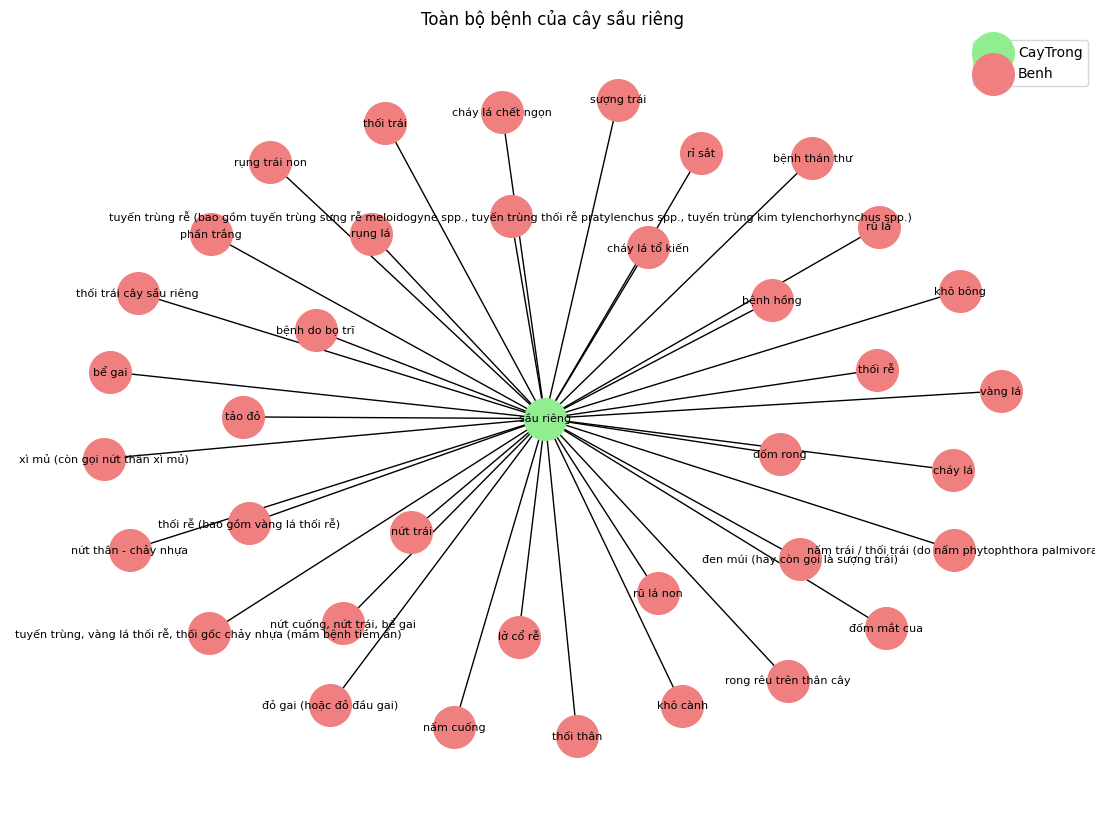

In [5]:
# Truy vấn tất cả các loại bệnh của cây sầu riêng
query_viz = """
MATCH (c:CayTrong {name: "sầu riêng"})-[:BI_MAC]->(b:Benh)
RETURN c, b
"""

run_query_with_viz(query_viz, "Toàn bộ bệnh của cây sầu riêng")

# Search information

## Search by cypher query

Template cypher

In [5]:
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain
import textwrap # Ensure textwrap is imported here as it's used in prettyCypherChain


In [ ]:
query_casebenh = f"""
    MATCH (cb:CaseBenh {{id: "sầu riêng-phấn trắng"}})-[:DO_NGUYEN_NHAN]->(nn:NguyenNhan)
    MATCH (cb)-[:CACH_DIEU_TRI]->(dt:DieuTri)
    RETURN nn.desc AS nguyen_nhan, dt.desc AS dieu_tri;
    """

graph.run(query_casebenh).data()

In [6]:
# Redefine CYPHER_GENERATION_TEMPLATE with escaped curly braces
CYPHER_GENERATION_TEMPLATE = """Task: Generate a Cypher statement to query a graph database.
Instructions:
- Analyze the question and extract relevant graph components dynamically. Use this to construct the Cypher query.
- Use only the relationship types and properties from the provided schema. Do not include any other relationship types, properties, or assumptions not defined in the schema.
- The schema is based on a graph structure with nodes and relationships as follows:
{schema}
- Return only the generated Cypher query in your response. Do not include explanations, comments, or additional text.
- Ensure the Cypher query directly addresses the given question using the schema accurately.

Examples:
# Cây {{tencay}} có thể bị mắc bệnh gì?
MATCH (c:CayTrong {{name: "{{tencay}}"}})-[:BI_MAC]->(b:Benh)
RETURN b.name AS benh;

# Những cây có thể mắc bệnh {{benh}}?
MATCH (c:CayTrong)-[:BI_MAC]->(b:Benh {{name: "{{benh}}"}})
RETURN c.name AS tencay;

# Cây lúa bị đạo ôn là do nguyên nhân gì (bỏ chữ cây, kết hợp thành case_benh=lúa-đạo ôn)
MATCH (cb:CaseBenh {{id: "{{case_benh}}"}})-[:DO_NGUYEN_NHAN]->(nn:NguyenNhan)
MATCH (cb)-[:CACH_DIEU_TRI]->(dt:DieuTri)
RETURN nn.desc AS nguyen_nhan, dt.desc AS dieu_tri;

# Những cây nào có thể bị bệnh thán thư
MATCH (c:CayTrong)-[:BI_MAC]->(b:Benh)
WHERE b.name = "thán thư"
RETURN DISTINCT c.name AS ten_cay;

The question is:
{question}
"""

In [9]:
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"],
    template=CYPHER_GENERATION_TEMPLATE
)

# Create a langchain_neo4j.Neo4jGraph object
neo4j_graph_langchain = Neo4jGraph(
    url="neo4j+s://f3d83d5c.databases.neo4j.io",
    username="neo4j",
    password="OdsKm9O5_yCws_0pxLaWZjVlzQNjElSg4Lc9ti25Q8s"
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0,
        google_api_key=API_key
    ),
    graph=neo4j_graph_langchain, # Pass the correct graph object here
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True
)

def prettyCypherChain(question: str) -> str:
    response = cypherChain.run(question)
    # print('---response', response)
    # print('===', cypherChain.invoke(question))
    return textwrap.fill(response, 60)

In [10]:
prettyCypherChain("Những cây nào bị bệnh cháy lá")

C:\Users\PC\AppData\Local\Temp\ipykernel_5648\2112648823.py:26: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain-classic 0.1.0 and will be removed in 1.0. Use `invoke` instead.
  response = cypherChain.run(question)




> Entering new GraphCypherQAChain chain...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised PermissionDenied: 403 Your API key was reported as leaked. Please use another API key..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised PermissionDenied: 403 Your API key was reported as leaked. Please use another API key..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised PermissionDenied: 403 Your API key was reported as leaked. Please use another API key..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 16.0 seconds as it raised PermissionDenied: 403 Your API key was reported as leaked. Please use another API key..


KeyboardInterrupt: 

## Search by Sematic search

In [12]:
import google.generativeai as genai_emb

genai_emb.configure(api_key=API_key)

In [13]:
@sleep_and_retry
@limits(calls=1500, period=60)
def get_embedding(text):
    try:
        result = genai_emb.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="retrieval_document",
        )
        return result['embedding']
    except Exception as e:
        print(f"Embedding error: {e}")
        return None

In [14]:
def semantic_search(node_label, text_field, embedding_field, query_text, top_k=5):
    """
    node_label:    label của node (Benh, TrieuChung...)
    text_field:    trường chứa text gốc (name hoặc desc)
    embedding_field: trường chứa embedding đã lưu
    query_text: text người dùng muốn tìm
    top_k: số lượng kết quả trả về
    """

    # 1. Lấy embedding cho câu query
    query_emb = get_embedding(query_text)
    if query_emb is None:
        print("Cannot get query embedding.")
        return []

    print(f"Query embedding length: {len(query_emb)}")

    # 2. Truy vấn tính cosine similarity trong Neo4j
    results = graph.run(f"""
    MATCH (n:{node_label})
    WHERE n.{embedding_field} IS NOT NULL

    WITH n,
        reduce( dot = 0.0, i in range(0, size(n.{embedding_field})-1) |
            dot + n.{embedding_field}[i] * $embedding[i]
        ) /
        (
            sqrt(reduce(a = 0.0, i in range(0, size(n.{embedding_field})-1) |
                a + n.{embedding_field}[i] * n.{embedding_field}[i]
            )) *
            sqrt(reduce(b = 0.0, i in range(0, size($embedding)-1) |
                b + $embedding[i] * $embedding[i]
            ))
        ) AS similarity

    WHERE similarity > 0
    RETURN
        n.cay AS cay,
        n.benh AS benh,
        n.description AS description,
        n.{text_field} AS text,
        similarity AS score
    ORDER BY similarity DESC
    LIMIT $top_k
    """, parameters={
        'embedding': query_emb,
        'top_k': top_k
    }).data()

    return results

In [15]:
results = semantic_search(
    node_label="CaseBenh",
    text_field="description",
    embedding_field="description_embedding",
    query_text="cà chua có triệu chứng có quả bị thối",
    top_k=5
)

Query embedding length: 768


In [ ]:
for r in results:
    print(f"\nCây: {r.get('cay', 'No name')}")
    print(f"Bệnh: {r.get('benh', 'N/A')}")
    # print(f"Mô tả bệnh: {r.get('description', 'N/A')}")
    print(f"Score: {r.get('score', 'N/A'):.3f}")
    desc = r.get('text', 'No description')
    print(f"Mô tả bệnh: {desc}")

## Search main

In [17]:
def extract_entities_and_relationships(text):
    # Initialize the OpenAI client
    # text = sample
    client = genai.Client(api_key=API_key)

    prompt = (
        f"You are the query-analysis system for a plant disease diagnosis chatbot using RAG + a Knowledge Graph.\n\n"
        f"Your tasks:\n\n"
        f"1. Determine whether the user’s query is related to plant diseases.\n"
        f"    - If the query is NOT related to plant diseases:\n"
        f"        * Return IsPlantDiseaseQuery = 0\n"
        f"        * Directly answer the user’s question in a clear and concise way.\n"
        f"        * Do NOT extract entities or relationships.\n\n"
        f"        * The answer MUST be in Vietnamese  "
        f"    - If the query IS related to plant diseases:\n"
        f"        * Return IsPlantDiseaseQuery = 1\n\n"
        f"2. When IsPlantDiseaseQuery = 1:\n"
        f"    - Extract all relevant entities according to the following node types:\n"
        f"        * TenCay (PlantName)\n"
        f"        * Benh (Disease)\n"
        f"        * NguyenNhan (Cause)\n"
        f"        * TrieuChung (Symptom)\n"
        f"        * DieuTri (Treatment)\n"
        f"    - Extract relationships using the following relationship types:\n"
        f"        * BI_MAC\n"
        f"        * CACH_DIEU_TRI\n"
        f"        * CO_TRIEU_CHUNG\n"
        f"        * CO_ID_BENH\n"
        f"        * CO_NGUYEN_NHAN\n\n"
        f"3. If the query contains multiple symptoms or multiple plant-disease descriptions, extract ALL corresponding entities and relationships.\n\n"
        f"4. All output must be in English and strictly follow the structure below.\n\n"
        f"   Do not add comments, explanations, or extra text.\n\n"
        f"Follow this format:\n\n"
        f"IsPlantDiseaseQuery: {{0 or 1}}\n\n"
        f"If IsPlantDiseaseQuery = 0:\n"
        f"Answer: '{{Your direct answer to the user’s question}}'\n\n"
        f"If IsPlantDiseaseQuery = 1:\n"
        f"Entities:\n"
        f"- {{EntityName}}: {{EntityType}}\n"
        f"...\n\n"
        f"Relationships:\n"
        f"- ({{Entity1}}, {{RelationshipType}}, {{Entity2}})\n"
        f"...\n\n"
        f"--------------------------------------------\n\n"
        f"Text:\n\"{text}\"\n\n"
    )


    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt],
        config={
            "temperature": 1,
            "top_p": 1,
            "max_output_tokens": 2048,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "response_mime_type": "text/plain"
        }
    )
    return response

In [43]:
def parse_gemini_response(raw_text: str):
    result = {
        "IsPlantDiseaseQuery": None,
        "Answer": None,
        "Entities": [],
        "Relationships": []
    }

    # Nếu raw_text = None thì trả về luôn kết quả mặc định
    if raw_text is None:
        return "Câu hỏi không hợp lệ"

    # --- 1. Extract IsPlantDiseaseQuery ---
    match_query = re.search(r"IsPlantDiseaseQuery:\s*(\d+)", raw_text)
    if match_query:
        result["IsPlantDiseaseQuery"] = int(match_query.group(1))

    # --- 2. Extract Answer (only for case 0) ---
    match_answer = re.search(r"Answer:\s*(.+)", raw_text)
    if match_answer:
        result["Answer"] = match_answer.group(1).strip()

    # --- 3. Extract Entities: lines like "- name: Type" ---
    entities_block = re.search(r"Entities:\s*(.*?)\n\n", raw_text, re.DOTALL)
    if entities_block:
        lines = entities_block.group(1).strip().split("\n")
        for line in lines:
            match_entity = re.match(r"-\s*(.+?):\s*(.+)", line.strip())
            if match_entity:
                entity_name = match_entity.group(1).strip()
                entity_type = match_entity.group(2).strip()
                result["Entities"].append({
                    "name": entity_name,
                    "type": entity_type
                })

    # --- 4. Extract Relationships: lines like "- (A, REL, B)" ---
    rel_block = re.search(r"Relationships:\s*(.*)", raw_text, re.DOTALL)
    if rel_block:
        lines = rel_block.group(1).strip().split("\n")
        for line in lines:
            match_rel = re.match(r"-\s*\((.+?),\s*(.+?),\s*(.+?)\)", line.strip())
            if match_rel:
                e1 = match_rel.group(1).strip()
                rel = match_rel.group(2).strip()
                e2 = match_rel.group(3).strip()
                result["Relationships"].append({
                    "entity1": e1,
                    "relationship": rel,
                    "entity2": e2
                })

    return result

In [40]:
def dedupe_diseases(blocks):
    seen = set()
    unique = []

    for block in blocks:
        disease = block.get("benh", "").strip().lower()

        if disease not in seen:
            seen.add(disease)
            unique.append(block)

    return unique

def remove_not_related(data_find, ten_cay):
    results = []
    for r in data_find:
        if ten_cay.strip() == r.get('cay').strip():
            results.append(r)

    return  results

def format_result(results_raw, ten_cay):
    results = remove_not_related(results_raw, ten_cay) # xóa những cây không liên quan
    results = dedupe_diseases(results) # xóa những bệnh lặp lại 2 lần
    return results

In [44]:
def query_by_input_text(query_text):
    response = extract_entities_and_relationships(query_text)

    result_after_parse = parse_gemini_response(response.text)

    results = []

    if result_after_parse["IsPlantDiseaseQuery"] == 0:
        return result_after_parse["Answer"]
    elif result_after_parse["IsPlantDiseaseQuery"] == 1:
        ten_cay = ""
        for relation in result_after_parse["Relationships"]:
            if relation['relationship'] == "CO_TRIEU_CHUNG":
                ten_cay = relation['entity1'].strip().lower()
                if ten_cay.startswith("cây "):
                    ten_cay = ten_cay[4:]

                query_text = ten_cay + " có các triệu chứng như sau: " + relation['entity2']

                print(query_text)

                results_sematic = semantic_search(
                                node_label="CaseBenh",
                                text_field="description",
                                embedding_field="description_embedding",
                                query_text=query_text,
                                top_k=5
                            )
                for r_se in results_sematic:
                    results.append(r_se)
            else:
                return prettyCypherChain(query_text)

        return format_result(results, ten_cay)

def query_by_casebenh(ten_cay, benh_cay):
    case_benh = f"{ten_cay}-{benh_cay}"
    query_casebenh = f"""
    MATCH (cb:CaseBenh {{id: "{case_benh}"}})-[:DO_NGUYEN_NHAN]->(nn:NguyenNhan)
    MATCH (cb)-[:CACH_DIEU_TRI]->(dt:DieuTri)
    RETURN nn.desc AS nguyen_nhan, dt.desc AS dieu_tri;
    """
    return graph.run(query_casebenh).data()

In [51]:
query1 = "Cây thanh long bị mủ ở lá và trái của nó còn có những vết màu đen kì lạ"
query2 = "nếu tôi có 1 phương trình bậc 2, làm thế nào để giải phương trình này"
query3 = "Cây ớt có kích thước lá non bị nhỏ, biến dạng, có màu vàng."
query4 = "Cây táo bị thối trái"
query5 = "Cây sầu riêng bị ngập nước, nên bị thối rể, xì mủ rụng lá"
query6 = "Cây lúa bị thối rễ là do nguyên nhân gì?"
query7 = "Cây mai vàng bị bệnh thán thư do nguyên nhân gì?"
results = query_by_input_text(query7)

TypeError: string indices must be integers, not 'str'

In [47]:
results

In [ ]:
for r in results:
    print(f"\nCây: {r.get('cay', 'No name')}")
    print(f"Bệnh: {r.get('benh', 'N/A')}")
    # print(f"Mô tả bệnh: {r.get('description', 'N/A')}")
    # print(f"Score: {r.get('score', 'N/A'):.3f}")
    desc = r.get('text', 'No description')
    print(f"Mô tả bệnh: {desc}")

In [ ]:
result = query_by_casebenh("sầu riêng", "phấn trắng")

In [ ]:
result